# Outline

1. Read in JSON into a flat Pandas DataFrame
2. Use Seaborn's pairplot() across columns to see if there are obvious relationships
3. Create hypotheses about the relationships between traits
4. Analyze whether those relationships exist
5. Analyze users
6. Graph/describe findings

In [1]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline 

# Reading in data

In [2]:
with open('bioprint-data.json') as data_file:    
    data = json.loads(data_file.read())

In [3]:
def flatten_biobots_data(data):
    out = []
    for entry in data:
        u_email = entry['user_info']['email']
        u_serial = entry['user_info']['serial']
        pd_dead = entry['print_data']['deadPercent']
        pd_elasticity = entry['print_data']['elasticity']
        pd_live = entry['print_data']['livePercent']
        pi_cl_dur = entry['print_info']['crosslinking']['cl_duration']
        pi_cl_enabled = entry['print_info']['crosslinking']['cl_enabled']
        pi_cl_intensity = entry['print_info']['crosslinking']['cl_intensity']
        pi_input = entry['print_info']['files']['input']
        pi_output = entry['print_info']['files']['output']
        pi_extr1 = entry['print_info']['pressure']['extruder1']
        pi_extr2 = entry['print_info']['pressure']['extruder2']
        pi_height = entry['print_info']['resolution']['layerHeight']
        pi_num = entry['print_info']['resolution']['layerNum']
        pi_wellplate = entry['print_info']['wellplate']
        out.append((u_email, u_serial, pd_dead, pd_elasticity, pd_live,
                    pi_cl_dur, pi_cl_enabled, pi_cl_intensity,
                    pi_input, pi_output, pi_extr1, pi_extr2, pi_height,
                    pi_num, pi_wellplate))
    cols = ('email', 'serial', 'dead', 'elasticity', 'live',
            'duration', 'enabled', 'intensity', 'input', 'output',
            'extruder1', 'extruder2', 'layer_height', 'layer_num', 'wellplate')
    return pd.DataFrame.from_records(out, columns = cols)

In [4]:
df = flatten_biobots_data(data)

In [5]:
df.describe()

serial          dead    elasticity          live     duration  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.00000   
mean      49.500000     34.672524     37.678562     60.478346   7543.55530   
std       28.867513     25.010282     24.856149     24.937274   9713.74483   
min        0.000000      0.010000      0.020000      0.000000      0.00000   
25%       24.750000     14.010000     19.307500     43.640000      0.00000   
50%       49.500000     30.150000     34.630000     64.770000    237.00000   
75%       74.250000     51.312500     48.920000     81.042500  15187.25000   
max       99.000000    100.000000    139.900000     99.690000  29996.00000   

          intensity     extruder1     extruder2  layer_height     layer_num  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      25.490500     59.621500     60.072200      0.502220     25.045300   
std       32.429713     34.507366     34.240786      0.259869     14.048124   
min        0.000000      1.000000      1.000000      0.100000      1.000000   
25%        0.000000     30.000000     31.000000      0.300000     13.000000   
50%        1.000000     59.000000     60.000000      0.500000     25.000000   
75%       52.000000     89.000000     90.000000      0.700000     37.000000   
max       99.000000    119.000000    119.000000      0.900000     49.000000   

          wellplate  
count  10000.000000  
mean      27.477100  
std       34.812711  
min        1.000000  
25%        6.000000  
50%       12.000000  
75%       24.000000  
max       96.000000

<p>After putting all of the data into a DataFrame, the describe() function will tease out any general descriptions of each column. First obvious note is that dead + live do not add up to 1. Second note is that most of the prints have a majority of live cells. Layer height and layer number seem to scale accordingly. Both extruders seem to have similar stats. To confirm, I plotted between these specific pairs.</p>

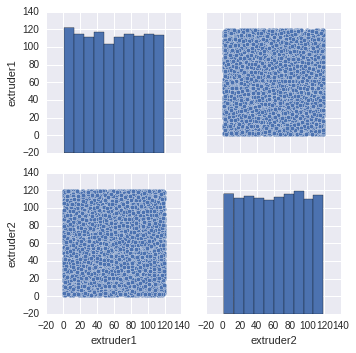

In [6]:
sns.pairplot(df[['extruder1', 'extruder2']])

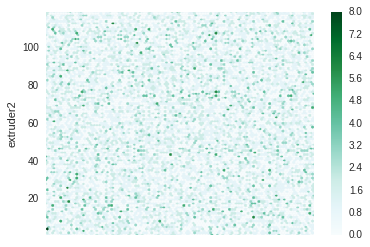

In [7]:
df.plot.hexbin(x='extruder1', y='extruder2')

No obvious relationship between extruder1 and extruder2 pressures, as far as I can tell. So I moved on to live/dead and layer number/height relationships. 

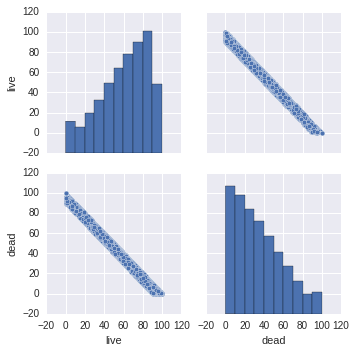

In [8]:
sns.pairplot(df[['live', 'dead']])

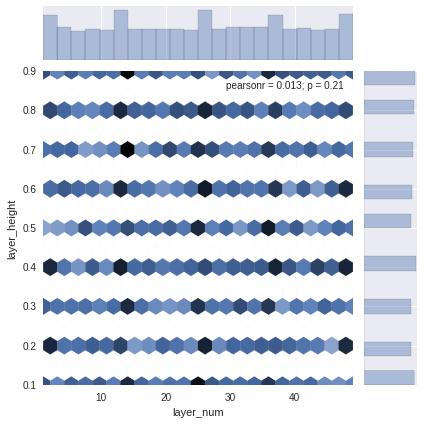

In [9]:
sns.jointplot('layer_num', 'layer_height', data=df, kind='hex')

Live and dead are negatively correlated (who would have thought?), but layer number and layer height don't seem to match any sort of pattern, which is surprising. 

Next, I wanted to scatter plot between two variables at a time. I excluded dead (due to its indirect linearity from live), extruder2, and layer number for simplicity sake.

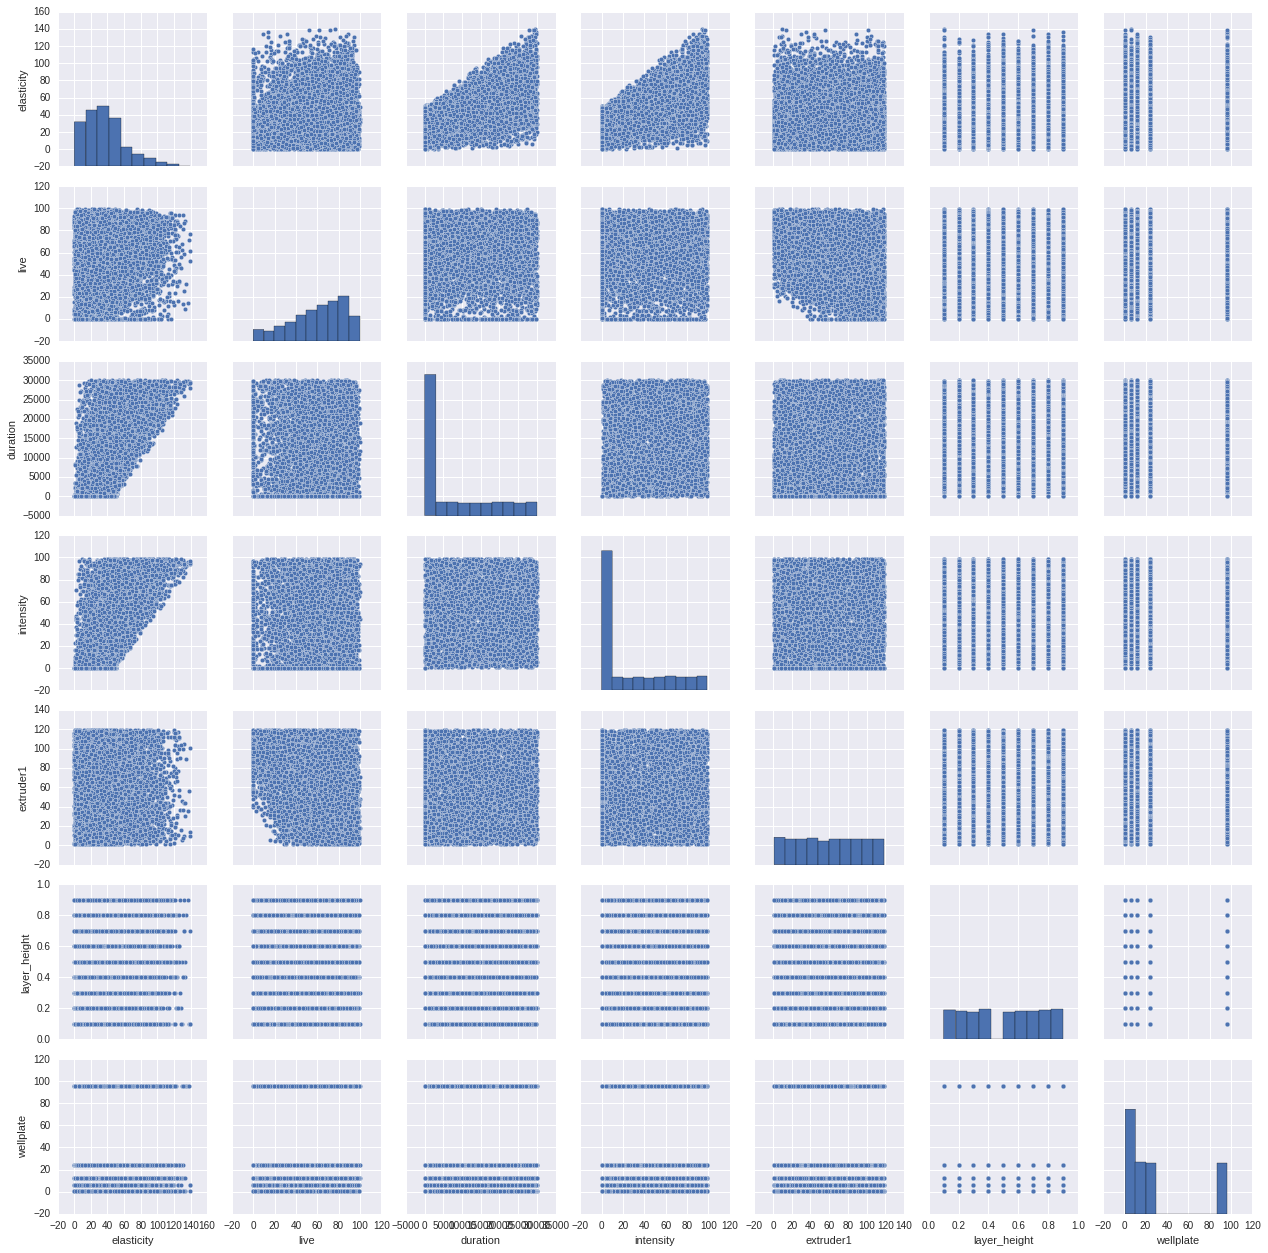

In [10]:
sns.pairplot(df[['elasticity', 'live', 'duration', 'intensity', 'extruder1', 'layer_height', 'wellplate']])

There are a handful of notable relationships here, which I will highlight in the below plots.

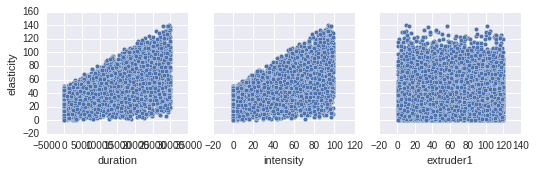

In [11]:
sns.pairplot(df, y_vars='elasticity', x_vars=['duration', 'intensity', 'extruder1'])

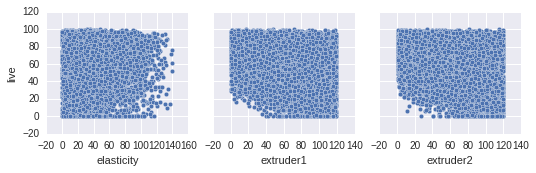

In [12]:
sns.pairplot(df, y_vars='live', x_vars=['elasticity', 'extruder1', 'extruder2'])

One of the stronger relationships are between elasticity and crosslinking duration/intensity. Recalling that the data included with whether crosslinking was enabled or not, I decided to plot what the difference was between elasticity for the group that had crosslinking vs the group that had not. 

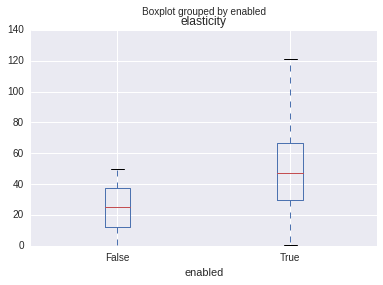

In [13]:
df.boxplot(column='elasticity', by='enabled')

In [14]:
cl_enabled = df[df.enabled == True]
cl_disabled = df[df.enabled == False]
print(cl_enabled.elasticity.median())
print(cl_disabled.elasticity.median())

47.32
24.84


There is a notable difference in the boxplot. The next question is whether this is statistically significant. Because they are different sample sizes and have different sample variance, it's wise to use the Welch's t-test when conducting statistical significance. 

In [15]:
stats.ttest_ind(cl_enabled.elasticity, cl_disabled.elasticity, equal_var=False)

Ttest_indResult(statistic=58.182482366600944, pvalue=0.0)

It's statistically significant. Now I want to see if there are any real differences between the relationships when split up into enabled/disabled crosslinking in other attributes.

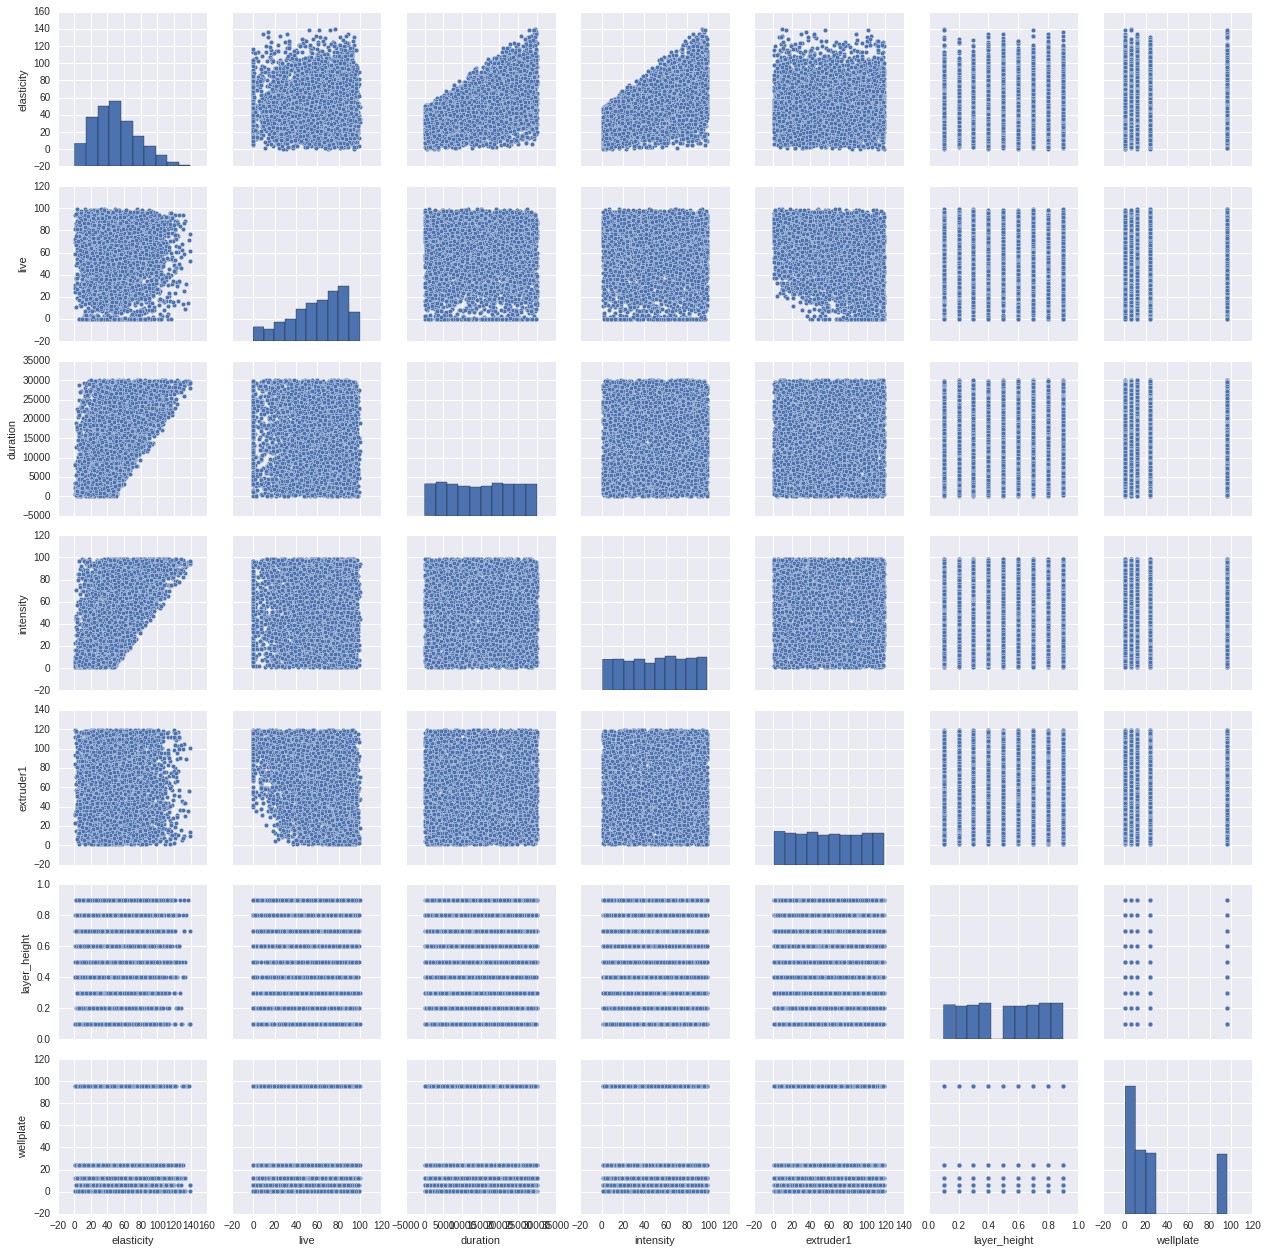

In [16]:
sns.pairplot(cl_enabled[['elasticity', 'live', 'duration', 'intensity', 'extruder1', 'layer_height', 'wellplate']])

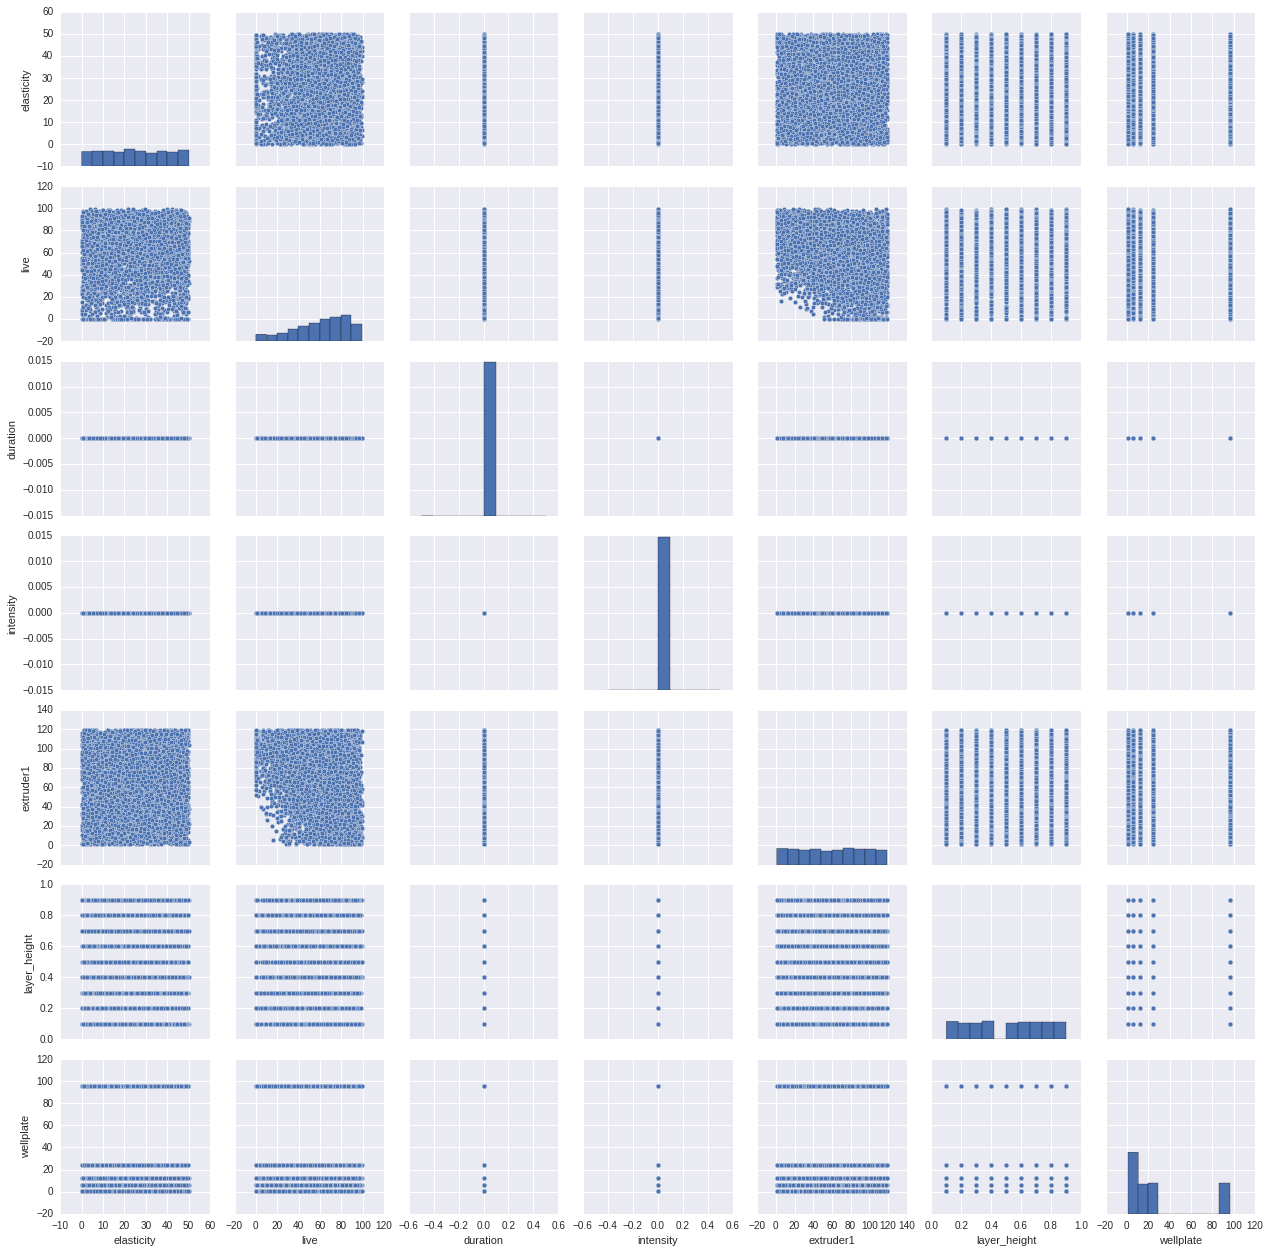

In [17]:
sns.pairplot(cl_disabled[['elasticity', 'live', 'duration', 'intensity', 'extruder1', 'layer_height', 'wellplate']])

Not much else to note aside from the relationship of elasticity. Elasticity is uniformly distributed with crosslinking-disabled prints, whereas it follows a normal distribution with a higher mean with cross-linking-enabled prints.

# User analysis

One of the more useful analysis would be regarding users of the product. Some things that would be worth looking into is if there are any users that use the prints more than others or if there are any differences between the elasticity or live counts of various users. 

In [18]:
user_ct = df[['serial', 'email']].groupby('serial').count()
user_ct.head()

email
serial       
0         100
1         100
2         100
3         100
4         100

In [19]:
print(max(user_ct.email))
print(min(user_ct.email))

100
100


No difference in print numbers per user. The next thing would be to see various attributes of users, such as mean live percent and mean elasticity. In order to see that, I want to look at 3 different graphs: looking at a histogram of mean live percentage and elasticity by user, a histogram of all live percentage and elasticity, and an ordered boxplot of live percentage and elasticity by user.

In [20]:
user_mean = df.groupby('serial').mean()

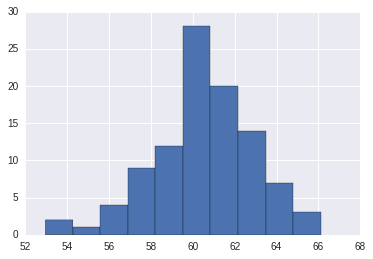

In [21]:
user_mean['live'].hist()

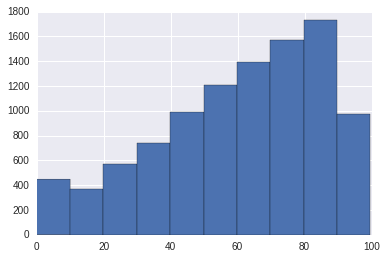

In [22]:
df.live.hist()

It seems like there is a little bit of sway in certain prints having a low percentage of live prints when looking at the entire population, but when looking at it on a by user basis, it follows a more normal distribution around 60%. This might mean there's more variance across prints, but that users correct for it over time. 

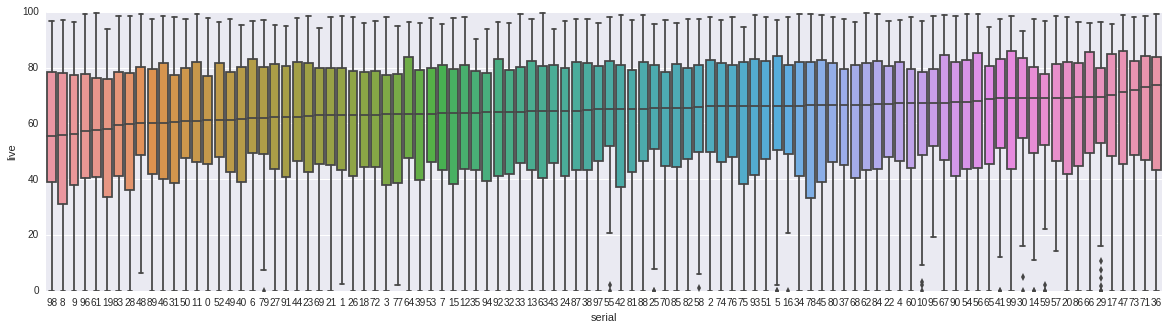

In [23]:
live_sorted = df[['serial', 'live']].groupby('serial').median().sort_values(by='live')
plt.figure(figsize=(20,5))
sns.boxplot(data=df, y='live', x='serial', order=live_sorted.index)

The above boxplots show live percentages by user, and it reveals which users have the highest live percentage prints (user 36) and which users have the lowest (user 98). If there were more context to each user, this could be incredibly insightful to see how users are using the printers. For example, user 55 has low dead percentage prints, so it could reveal more about that user's priorities.

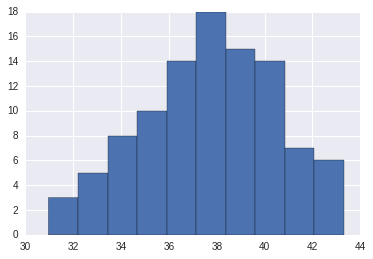

In [24]:
user_mean['elasticity'].hist()

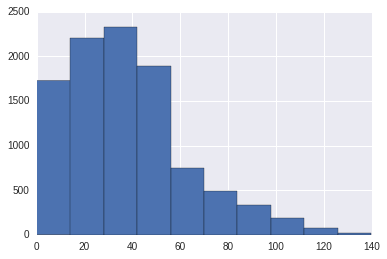

In [25]:
df.elasticity.hist()

Elasticity follows a different skew. The means are still normally distributed, but the overall population skews towards low elasticity. This is likely due to the fact the earlier relationship of crosslinking and elasticity. Crosslinking-disabled prints mean lower and more uniform elasticity, so the fact that those are included in this histogram skews downwards. Because the means are still Guassian, it looks like crosslinking isn't tied to any particular user based on the aggregation.

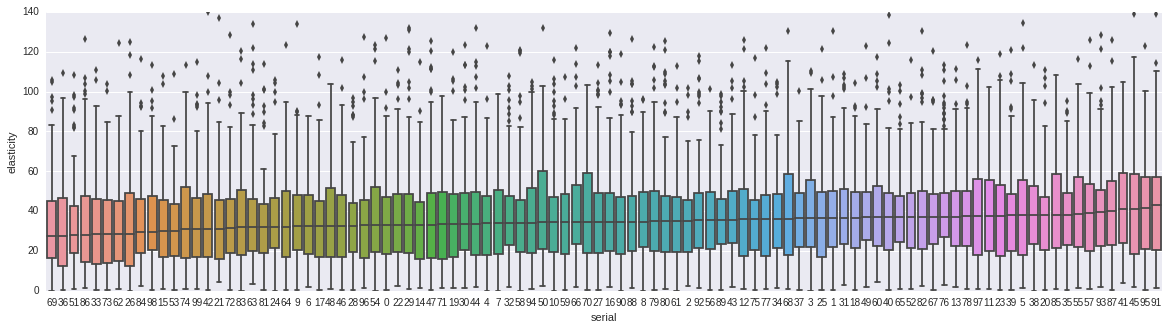

In [26]:
live_sorted = df[['serial', 'elasticity']].groupby('serial').median().sort_values(by='elasticity')
plt.figure(figsize=(20,5))
sns.boxplot(data=df, y='elasticity', x='serial', order=live_sorted.index)

Next I want to see if there are differing relationships between live and extruder pressure. For simplicity sake, I am looking at extruder 1.

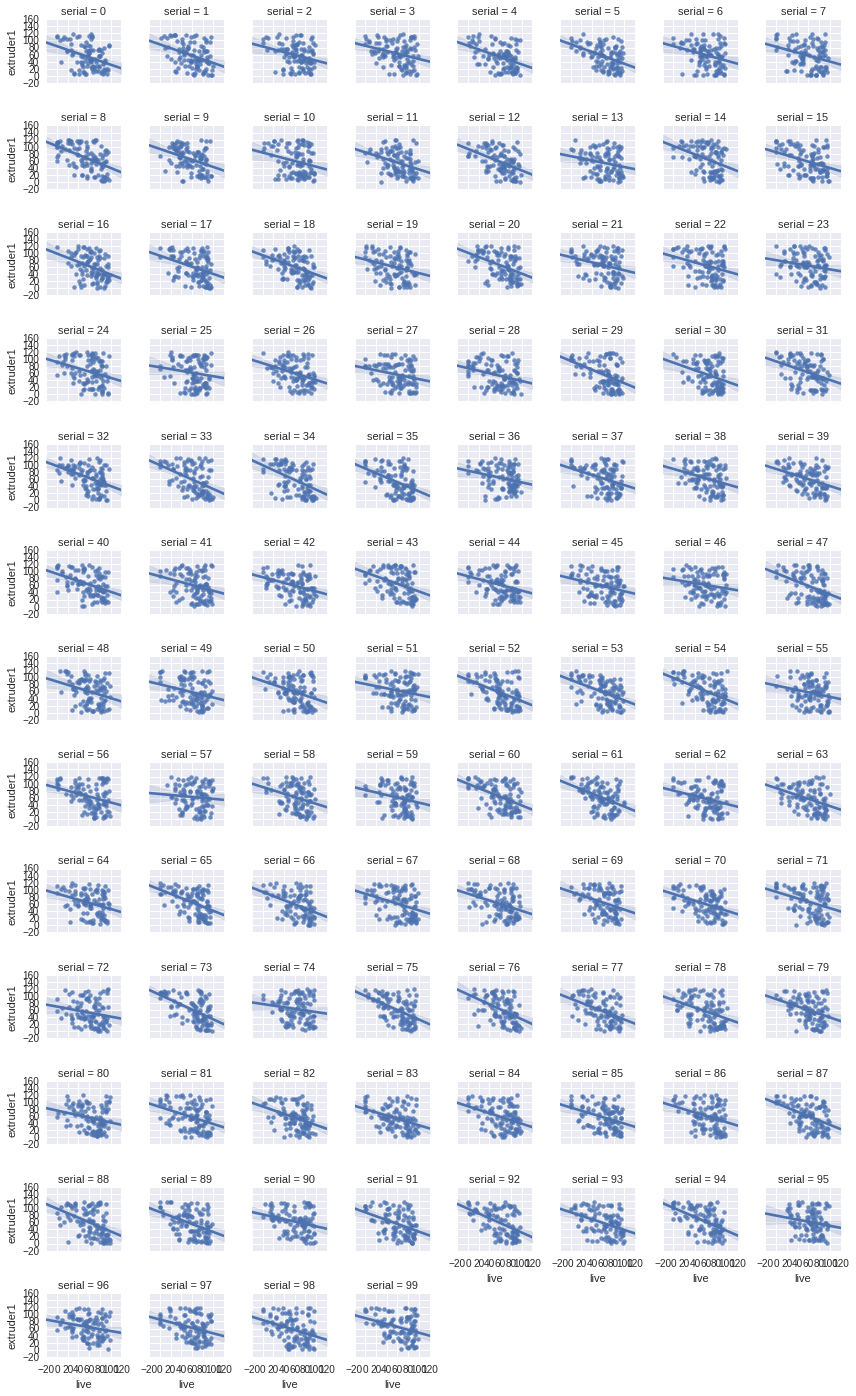

In [27]:
g = sns.FacetGrid(df[['serial', 'live', 'extruder1']], col='serial', col_wrap=8, size=1.5,)
g = g.map(sns.regplot, "live", "extruder1")

Regardless of user, there is a negative relationship between live percentage and extruder pressure. This is interesting, because it confirms the hypothesis of whether higher pressure would kill cells more. Next I want to be able to look at both extruder 1 and extruder 2 in the same plot.

In [28]:
df_flat_ext = pd.melt(df[['serial', 'live', 'extruder1', 'extruder2']], id_vars = ['serial', 'live'], var_name='extruder', value_name='value')
df_flat_ext.head()

serial   live   extruder  value
0       0   7.02  extruder1   38.0
1       0  37.42  extruder1  109.0
2       0  84.41  extruder1   64.0
3       0  37.87  extruder1   38.0
4       0  68.57  extruder1   18.0

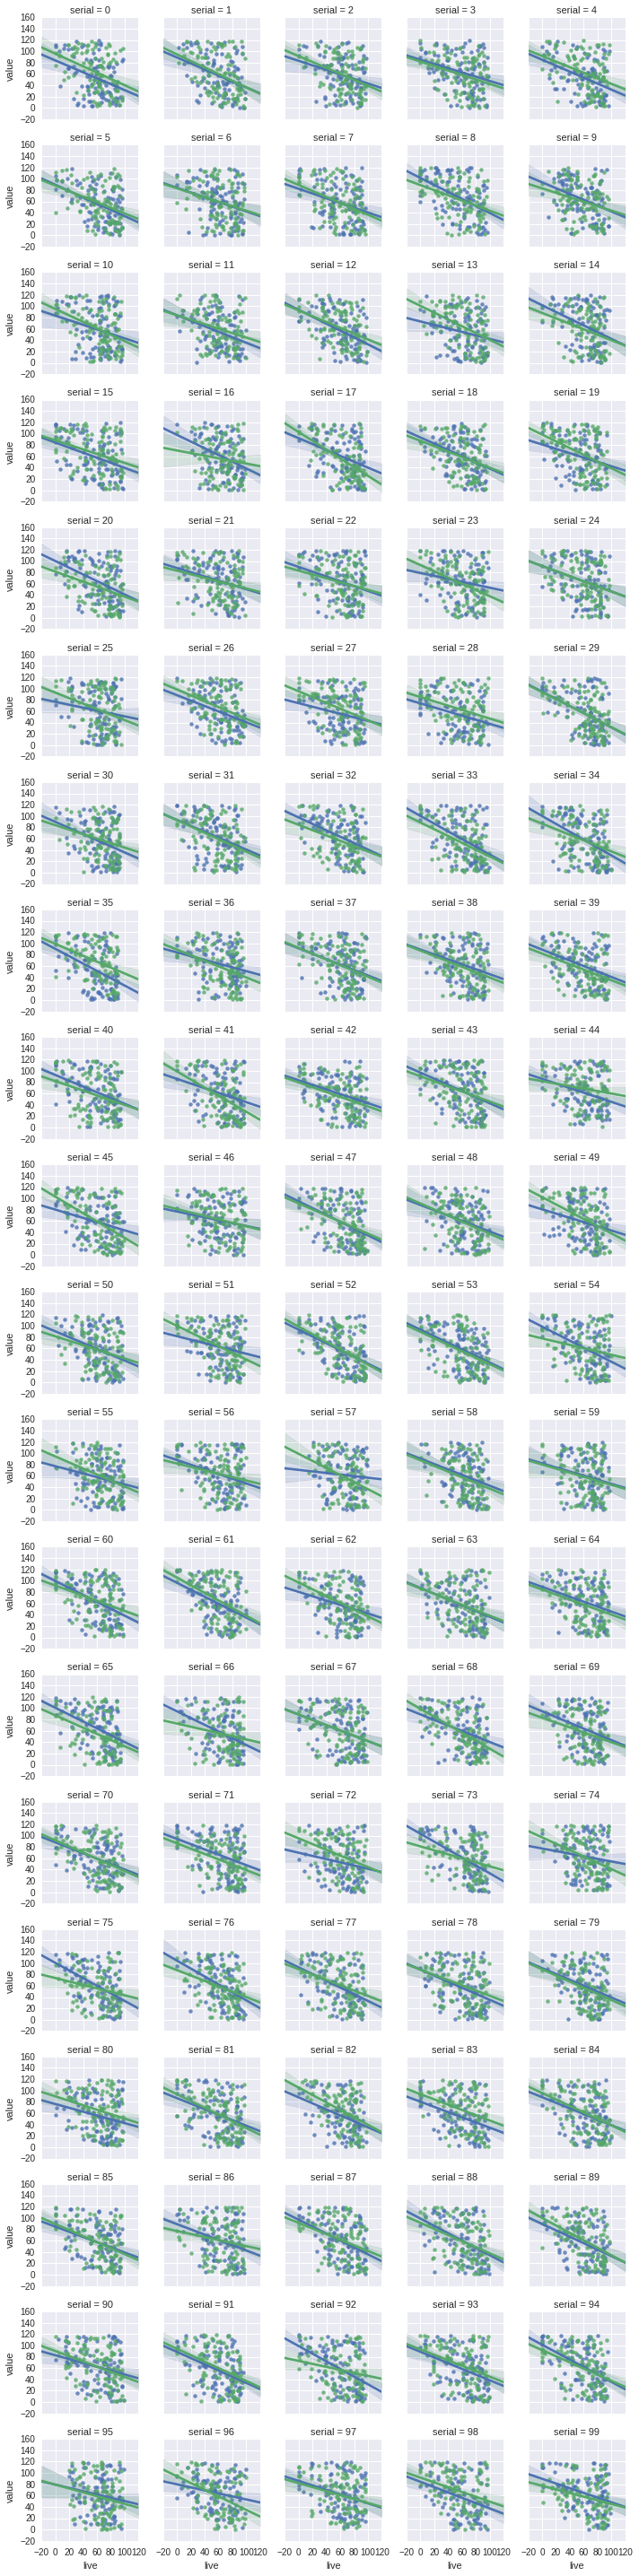

In [29]:
df_flat_ext = pd.melt(df[['serial', 'live', 'extruder1', 'extruder2']], id_vars = ['serial', 'live'], var_name='extruder', value_name='value')
df_flat_ext.head()

g = sns.FacetGrid(df_flat_ext, col='serial', hue='extruder', col_wrap=5, size=2,)
g = g.map(sns.regplot, "live", "value")

Extruder 2 follows the same patterns as extruder 1. That means that there is still similarities between extruder 1 and extruder 2 that was not quite uncovered during the earlier pairplots and hexplots. They could be collinear for regression models. 

# Conclusion

A lot more data can make this initial descriptive analysis even more useful, such as time of prints (to turn this into a time-series problem) and more context surrounding users and the printer's usage. In this exploratory analysis, there seems to be a definitive relationship between elasticity and crosslinking. Additionally, live counts are negatively correlated with extruder pressure. While extruder pressure are not directly correlated with each other, they are correlated to live percentage, which could reveal an underlying relationship.